In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
look_back      = params.look_back_tick 
features_cols  = params.features_cols_tick
label_col      = params.label_col
device         = params.device

df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)

df_features = df_feat[features_cols + ['signal','ask','bid']]
df_features 

,vol_15,ma_5,ma_20,close,hour,bb_width_20,high,low,open,vwap_dev,atr_14,r_5,r_1,r_15,obv,signal,ask,bid
2004-01-02 13:09:00,-0.966783,-0.185561,-0.282361,-0.193762,0.493,-0.929333,-0.317313,-0.028125,-0.193147,-0.032030,-1.435516,-0.040971,-0.029212,-0.025534,11.535427,0.005593,0.764807,0.763664
2004-01-02 13:10:00,-0.965007,-0.192087,-0.284115,-0.201725,0.493,-0.921566,-0.324262,-0.037500,-0.201085,-0.036171,-1.432540,-0.054390,-0.029213,-0.033477,11.491025,0.006095,0.764790,0.763647
2004-01-02 13:11:00,-0.963779,-0.200245,-0.286307,-0.209688,0.493,-0.913246,-0.331210,-0.046875,-0.209022,-0.040262,-1.429563,-0.067809,-0.029214,-0.041420,11.441197,0.006642,0.764773,0.763631
2004-01-02 13:12:00,-0.963001,-0.208402,-0.288939,-0.217651,0.493,-0.904541,-0.338159,-0.056250,-0.216960,-0.044296,-1.426587,-0.067810,-0.029214,-0.049363,11.385942,0.007239,0.764757,0.763614
2004-01-02 13:13:00,-0.962622,-0.216560,-0.292008,-0.225614,0.493,-0.895592,-0.345107,-0.065625,-0.224897,-0.048268,-1.423611,-0.067812,-0.029215,-0.057307,11.325262,0.007889,0.764740,0.763597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.507307,0.367023,-0.130453,0.705997,-0.939,0.122381,0.704918,0.500000,0.475806,0.407906,2.024482,1.742521,0.837991,1.317936,0.839704,0.000000,196.962600,196.667400
2025-06-18 20:57:00,0.566581,0.460866,-0.093452,0.478780,-0.939,0.187641,0.836066,0.387097,0.685484,0.263954,2.207440,0.887590,-0.939239,1.115397,0.647913,0.000000,196.822500,196.527500
2025-06-18 20:58:00,0.542508,0.497086,-0.060109,0.470665,-0.939,0.241322,0.508197,0.500000,0.467742,0.254269,2.216153,0.341995,-0.033854,0.828890,0.429218,0.000000,196.817500,196.522500
2025-06-18 20:59:00,0.903328,0.408182,-0.062549,-0.227217,-0.939,0.245429,0.524590,-0.129032,0.475806,-0.173638,2.487280,-0.842944,-2.888426,-0.094079,-0.434952,0.043551,196.387200,196.092800


In [4]:
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = params.look_back_tick,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    return_col    = params.return_col,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape,    "(samples,)")
print("  y_ret     =", y_ret.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2270503, 30, 15]) (samples, look_back, features)
  y_sig     = torch.Size([2270503]) (samples,)
  y_ret     = torch.Size([2270503]) (samples,)
  raw_close = torch.Size([2270503])
  raw_bid   = torch.Size([2270503])
  raw_ask   = torch.Size([2270503])
  end_times = (2270503,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1600443, 30, 15])
  y_sig_tr, y_ret_tr = torch.Size([1600443]) torch.Size([1600443])
  X_val = torch.Size([329639, 30, 15])
  y_sig_val, y_ret_val = torch.Size([329639]) torch.Size([329639])
  X_te  = torch.Size([340421, 30, 15])
  y_sig_te, y_ret_te = torch.Size([340421]) torch.Size([340421])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = len(features_cols),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 32, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.15, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [9]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

Training sees 3808 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.285996


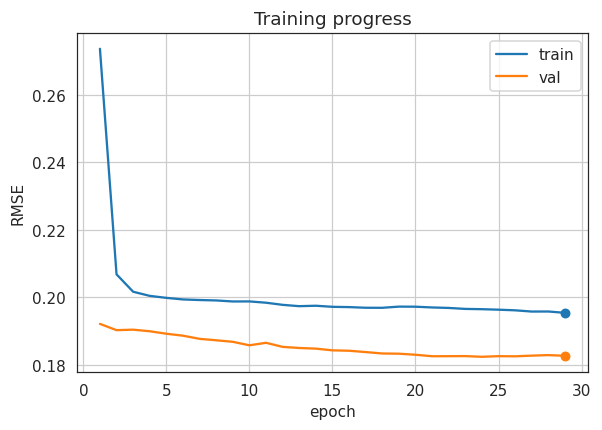

Epoch 1:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 001
TRAIN→ "R": RMSE=0.2736 MAE=0.1973 R2=-0.4933 | "B": Acc=0.7953 Prec=0.4404 Rec=0.1822 F1=0.2577 AUROC=0.7392 | "T": Acc=0.3640 Prec=0.3924 Rec=0.3640 F1=0.3703 AUROC=0.5801
VALID→ "R": RMSE=0.1921 MAE=0.1398 R2=0.1962 | "B": Acc=0.8170 Prec=0.6802 Rec=0.0631 F1=0.1155 AUROC=0.7769 | "T": Acc=0.3608 Prec=0.6063 Rec=0.3608 F1=0.3606 AUROC=0.5751


Epoch 2:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 002
TRAIN→ "R": RMSE=0.2068 MAE=0.1470 R2=0.1472 | "B": Acc=0.8110 Prec=0.5560 Rec=0.1540 F1=0.2412 AUROC=0.7657 | "T": Acc=0.3485 Prec=0.4582 Rec=0.3485 F1=0.3415 AUROC=0.5687
VALID→ "R": RMSE=0.1903 MAE=0.1345 R2=0.2117 | "B": Acc=0.8177 Prec=0.7077 Rec=0.0631 F1=0.1159 AUROC=0.7828 | "T": Acc=0.3586 Prec=0.5714 Rec=0.3586 F1=0.3659 AUROC=0.5806


Epoch 3:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 003
TRAIN→ "R": RMSE=0.2016 MAE=0.1436 R2=0.1892 | "B": Acc=0.8135 Prec=0.5734 Rec=0.1706 F1=0.2629 AUROC=0.7708 | "T": Acc=0.3531 Prec=0.4806 Rec=0.3531 F1=0.3474 AUROC=0.5731
VALID→ "R": RMSE=0.1904 MAE=0.1331 R2=0.2105 | "B": Acc=0.8208 Prec=0.6812 Rec=0.1008 F1=0.1757 AUROC=0.7844 | "T": Acc=0.3608 Prec=0.5663 Rec=0.3608 F1=0.3655 AUROC=0.5839


Epoch 4:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 004
TRAIN→ "R": RMSE=0.2004 MAE=0.1424 R2=0.1990 | "B": Acc=0.8145 Prec=0.5812 Rec=0.1746 F1=0.2685 AUROC=0.7733 | "T": Acc=0.3553 Prec=0.4938 Rec=0.3553 F1=0.3497 AUROC=0.5757
VALID→ "R": RMSE=0.1899 MAE=0.1320 R2=0.2144 | "B": Acc=0.8221 Prec=0.6614 Rec=0.1231 F1=0.2075 AUROC=0.7862 | "T": Acc=0.3636 Prec=0.5847 Rec=0.3636 F1=0.3691 AUROC=0.5857


Epoch 5:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 005
TRAIN→ "R": RMSE=0.1998 MAE=0.1418 R2=0.2037 | "B": Acc=0.8151 Prec=0.5867 Rec=0.1767 F1=0.2716 AUROC=0.7745 | "T": Acc=0.3567 Prec=0.5089 Rec=0.3567 F1=0.3511 AUROC=0.5765
VALID→ "R": RMSE=0.1892 MAE=0.1318 R2=0.2204 | "B": Acc=0.8225 Prec=0.6588 Rec=0.1290 F1=0.2157 AUROC=0.7870 | "T": Acc=0.3632 Prec=0.5765 Rec=0.3632 F1=0.3692 AUROC=0.5861


Epoch 6:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 006
TRAIN→ "R": RMSE=0.1994 MAE=0.1415 R2=0.2074 | "B": Acc=0.8153 Prec=0.5884 Rec=0.1773 F1=0.2725 AUROC=0.7755 | "T": Acc=0.3578 Prec=0.5099 Rec=0.3578 F1=0.3528 AUROC=0.5760
VALID→ "R": RMSE=0.1886 MAE=0.1320 R2=0.2252 | "B": Acc=0.8226 Prec=0.6608 Rec=0.1294 F1=0.2164 AUROC=0.7876 | "T": Acc=0.3636 Prec=0.5794 Rec=0.3636 F1=0.3704 AUROC=0.5862


Epoch 7:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 007
TRAIN→ "R": RMSE=0.1992 MAE=0.1412 R2=0.2088 | "B": Acc=0.8156 Prec=0.5916 Rec=0.1770 F1=0.2725 AUROC=0.7762 | "T": Acc=0.3582 Prec=0.5130 Rec=0.3582 F1=0.3534 AUROC=0.5763
VALID→ "R": RMSE=0.1877 MAE=0.1318 R2=0.2329 | "B": Acc=0.8238 Prec=0.6526 Rec=0.1477 F1=0.2408 AUROC=0.7884 | "T": Acc=0.3631 Prec=0.5808 Rec=0.3631 F1=0.3681 AUROC=0.5869


Epoch 8:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 008
TRAIN→ "R": RMSE=0.1991 MAE=0.1411 R2=0.2098 | "B": Acc=0.8160 Prec=0.5939 Rec=0.1791 F1=0.2752 AUROC=0.7768 | "T": Acc=0.3579 Prec=0.5161 Rec=0.3579 F1=0.3530 AUROC=0.5742
VALID→ "R": RMSE=0.1873 MAE=0.1319 R2=0.2364 | "B": Acc=0.8238 Prec=0.6482 Rec=0.1509 F1=0.2448 AUROC=0.7892 | "T": Acc=0.3635 Prec=0.5819 Rec=0.3635 F1=0.3695 AUROC=0.5871


Epoch 9:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 009
TRAIN→ "R": RMSE=0.1988 MAE=0.1408 R2=0.2122 | "B": Acc=0.8161 Prec=0.5935 Rec=0.1819 F1=0.2784 AUROC=0.7775 | "T": Acc=0.3582 Prec=0.5154 Rec=0.3582 F1=0.3535 AUROC=0.5736
VALID→ "R": RMSE=0.1868 MAE=0.1316 R2=0.2400 | "B": Acc=0.8247 Prec=0.6483 Rec=0.1623 F1=0.2596 AUROC=0.7904 | "T": Acc=0.3644 Prec=0.5840 Rec=0.3644 F1=0.3714 AUROC=0.5875


Epoch 10:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 010
TRAIN→ "R": RMSE=0.1988 MAE=0.1408 R2=0.2121 | "B": Acc=0.8163 Prec=0.5913 Rec=0.1876 F1=0.2848 AUROC=0.7782 | "T": Acc=0.3578 Prec=0.5069 Rec=0.3578 F1=0.3525 AUROC=0.5727
VALID→ "R": RMSE=0.1858 MAE=0.1310 R2=0.2485 | "B": Acc=0.8268 Prec=0.6443 Rec=0.1895 F1=0.2928 AUROC=0.7923 | "T": Acc=0.3651 Prec=0.5879 Rec=0.3651 F1=0.3744 AUROC=0.5884


Epoch 11:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 011
TRAIN→ "R": RMSE=0.1984 MAE=0.1405 R2=0.2151 | "B": Acc=0.8171 Prec=0.5931 Rec=0.1992 F1=0.2982 AUROC=0.7807 | "T": Acc=0.3588 Prec=0.5010 Rec=0.3588 F1=0.3542 AUROC=0.5729
VALID→ "R": RMSE=0.1865 MAE=0.1302 R2=0.2424 | "B": Acc=0.8274 Prec=0.6630 Rec=0.1790 F1=0.2819 AUROC=0.7952 | "T": Acc=0.3635 Prec=0.5846 Rec=0.3635 F1=0.3718 AUROC=0.5877


Epoch 12:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 012
TRAIN→ "R": RMSE=0.1978 MAE=0.1400 R2=0.2201 | "B": Acc=0.8179 Prec=0.5962 Rec=0.2051 F1=0.3052 AUROC=0.7831 | "T": Acc=0.3586 Prec=0.5074 Rec=0.3586 F1=0.3540 AUROC=0.5742
VALID→ "R": RMSE=0.1853 MAE=0.1299 R2=0.2522 | "B": Acc=0.8279 Prec=0.6391 Rec=0.2088 F1=0.3148 AUROC=0.7965 | "T": Acc=0.3624 Prec=0.5990 Rec=0.3624 F1=0.3674 AUROC=0.5872


Epoch 13:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 013
TRAIN→ "R": RMSE=0.1974 MAE=0.1397 R2=0.2232 | "B": Acc=0.8185 Prec=0.5981 Rec=0.2115 F1=0.3125 AUROC=0.7843 | "T": Acc=0.3597 Prec=0.5115 Rec=0.3597 F1=0.3556 AUROC=0.5738
VALID→ "R": RMSE=0.1850 MAE=0.1301 R2=0.2549 | "B": Acc=0.8277 Prec=0.6253 Rec=0.2239 F1=0.3297 AUROC=0.7961 | "T": Acc=0.3631 Prec=0.6016 Rec=0.3631 F1=0.3700 AUROC=0.5890


Epoch 14:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 014
TRAIN→ "R": RMSE=0.1975 MAE=0.1397 R2=0.2222 | "B": Acc=0.8187 Prec=0.5989 Rec=0.2127 F1=0.3139 AUROC=0.7851 | "T": Acc=0.3603 Prec=0.5181 Rec=0.3603 F1=0.3566 AUROC=0.5732
VALID→ "R": RMSE=0.1848 MAE=0.1298 R2=0.2564 | "B": Acc=0.8284 Prec=0.6376 Rec=0.2170 F1=0.3238 AUROC=0.7978 | "T": Acc=0.3635 Prec=0.5899 Rec=0.3635 F1=0.3712 AUROC=0.5891


Epoch 15:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 015
TRAIN→ "R": RMSE=0.1972 MAE=0.1396 R2=0.2247 | "B": Acc=0.8188 Prec=0.5987 Rec=0.2148 F1=0.3162 AUROC=0.7858 | "T": Acc=0.3607 Prec=0.5139 Rec=0.3607 F1=0.3573 AUROC=0.5720
VALID→ "R": RMSE=0.1843 MAE=0.1295 R2=0.2605 | "B": Acc=0.8292 Prec=0.6392 Rec=0.2249 F1=0.3327 AUROC=0.7982 | "T": Acc=0.3631 Prec=0.5969 Rec=0.3631 F1=0.3702 AUROC=0.5890


Epoch 16:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 016
TRAIN→ "R": RMSE=0.1971 MAE=0.1394 R2=0.2254 | "B": Acc=0.8192 Prec=0.6019 Rec=0.2154 F1=0.3173 AUROC=0.7862 | "T": Acc=0.3613 Prec=0.5149 Rec=0.3613 F1=0.3580 AUROC=0.5714
VALID→ "R": RMSE=0.1842 MAE=0.1296 R2=0.2614 | "B": Acc=0.8291 Prec=0.6439 Rec=0.2177 F1=0.3254 AUROC=0.7983 | "T": Acc=0.3630 Prec=0.5973 Rec=0.3630 F1=0.3700 AUROC=0.5884


Epoch 17:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 017
TRAIN→ "R": RMSE=0.1969 MAE=0.1393 R2=0.2269 | "B": Acc=0.8194 Prec=0.6033 Rec=0.2167 F1=0.3188 AUROC=0.7869 | "T": Acc=0.3615 Prec=0.5165 Rec=0.3615 F1=0.3585 AUROC=0.5703
VALID→ "R": RMSE=0.1838 MAE=0.1294 R2=0.2646 | "B": Acc=0.8297 Prec=0.6430 Rec=0.2259 F1=0.3343 AUROC=0.7985 | "T": Acc=0.3624 Prec=0.6006 Rec=0.3624 F1=0.3670 AUROC=0.5888


Epoch 18:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 018
TRAIN→ "R": RMSE=0.1969 MAE=0.1393 R2=0.2270 | "B": Acc=0.8194 Prec=0.6023 Rec=0.2183 F1=0.3204 AUROC=0.7872 | "T": Acc=0.3617 Prec=0.5187 Rec=0.3617 F1=0.3589 AUROC=0.5698
VALID→ "R": RMSE=0.1833 MAE=0.1296 R2=0.2679 | "B": Acc=0.8299 Prec=0.6439 Rec=0.2271 F1=0.3358 AUROC=0.7991 | "T": Acc=0.3630 Prec=0.5898 Rec=0.3630 F1=0.3668 AUROC=0.5899


Epoch 19:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 019
TRAIN→ "R": RMSE=0.1972 MAE=0.1395 R2=0.2243 | "B": Acc=0.8194 Prec=0.6021 Rec=0.2179 F1=0.3200 AUROC=0.7870 | "T": Acc=0.3618 Prec=0.5251 Rec=0.3618 F1=0.3589 AUROC=0.5684
VALID→ "R": RMSE=0.1833 MAE=0.1297 R2=0.2684 | "B": Acc=0.8297 Prec=0.6434 Rec=0.2257 F1=0.3342 AUROC=0.7989 | "T": Acc=0.3628 Prec=0.6004 Rec=0.3628 F1=0.3669 AUROC=0.5891


Epoch 20:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 020
TRAIN→ "R": RMSE=0.1972 MAE=0.1395 R2=0.2245 | "B": Acc=0.8196 Prec=0.6030 Rec=0.2190 F1=0.3214 AUROC=0.7875 | "T": Acc=0.3620 Prec=0.5254 Rec=0.3620 F1=0.3590 AUROC=0.5685
VALID→ "R": RMSE=0.1830 MAE=0.1304 R2=0.2709 | "B": Acc=0.8300 Prec=0.6455 Rec=0.2267 F1=0.3356 AUROC=0.7990 | "T": Acc=0.3633 Prec=0.6001 Rec=0.3633 F1=0.3691 AUROC=0.5895


Epoch 21:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 021
TRAIN→ "R": RMSE=0.1970 MAE=0.1393 R2=0.2262 | "B": Acc=0.8197 Prec=0.6047 Rec=0.2184 F1=0.3209 AUROC=0.7875 | "T": Acc=0.3625 Prec=0.5331 Rec=0.3625 F1=0.3599 AUROC=0.5684
VALID→ "R": RMSE=0.1825 MAE=0.1307 R2=0.2744 | "B": Acc=0.8308 Prec=0.6447 Rec=0.2372 F1=0.3468 AUROC=0.7991 | "T": Acc=0.3636 Prec=0.5968 Rec=0.3636 F1=0.3674 AUROC=0.5902


Epoch 22:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 022
TRAIN→ "R": RMSE=0.1968 MAE=0.1393 R2=0.2273 | "B": Acc=0.8198 Prec=0.6040 Rec=0.2206 F1=0.3231 AUROC=0.7878 | "T": Acc=0.3622 Prec=0.5302 Rec=0.3622 F1=0.3593 AUROC=0.5685
VALID→ "R": RMSE=0.1825 MAE=0.1315 R2=0.2743 | "B": Acc=0.8307 Prec=0.6518 Rec=0.2272 F1=0.3370 AUROC=0.7991 | "T": Acc=0.3630 Prec=0.5915 Rec=0.3630 F1=0.3649 AUROC=0.5908


Epoch 23:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 023
TRAIN→ "R": RMSE=0.1966 MAE=0.1391 R2=0.2296 | "B": Acc=0.8198 Prec=0.6046 Rec=0.2201 F1=0.3227 AUROC=0.7879 | "T": Acc=0.3634 Prec=0.5354 Rec=0.3634 F1=0.3607 AUROC=0.5686
VALID→ "R": RMSE=0.1826 MAE=0.1311 R2=0.2741 | "B": Acc=0.8308 Prec=0.6470 Rec=0.2337 F1=0.3434 AUROC=0.7989 | "T": Acc=0.3635 Prec=0.5955 Rec=0.3635 F1=0.3663 AUROC=0.5910


Epoch 24:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 024
TRAIN→ "R": RMSE=0.1965 MAE=0.1391 R2=0.2302 | "B": Acc=0.8200 Prec=0.6047 Rec=0.2222 F1=0.3250 AUROC=0.7883 | "T": Acc=0.3630 Prec=0.5410 Rec=0.3630 F1=0.3601 AUROC=0.5690
VALID→ "R": RMSE=0.1824 MAE=0.1317 R2=0.2757 | "B": Acc=0.8307 Prec=0.6443 Rec=0.2364 F1=0.3459 AUROC=0.7987 | "T": Acc=0.3637 Prec=0.5797 Rec=0.3637 F1=0.3656 AUROC=0.5913


Epoch 25:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 025
TRAIN→ "R": RMSE=0.1963 MAE=0.1390 R2=0.2314 | "B": Acc=0.8201 Prec=0.6053 Rec=0.2231 F1=0.3261 AUROC=0.7883 | "T": Acc=0.3630 Prec=0.5349 Rec=0.3630 F1=0.3600 AUROC=0.5687
VALID→ "R": RMSE=0.1825 MAE=0.1310 R2=0.2743 | "B": Acc=0.8309 Prec=0.6432 Rec=0.2393 F1=0.3489 AUROC=0.7981 | "T": Acc=0.3633 Prec=0.5803 Rec=0.3633 F1=0.3639 AUROC=0.5911


Epoch 26:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 026
TRAIN→ "R": RMSE=0.1961 MAE=0.1390 R2=0.2328 | "B": Acc=0.8202 Prec=0.6054 Rec=0.2249 F1=0.3280 AUROC=0.7886 | "T": Acc=0.3634 Prec=0.5448 Rec=0.3634 F1=0.3607 AUROC=0.5681
VALID→ "R": RMSE=0.1825 MAE=0.1312 R2=0.2747 | "B": Acc=0.8310 Prec=0.6404 Rec=0.2447 F1=0.3541 AUROC=0.7981 | "T": Acc=0.3637 Prec=0.5826 Rec=0.3637 F1=0.3636 AUROC=0.5917


Epoch 27:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 027
TRAIN→ "R": RMSE=0.1958 MAE=0.1387 R2=0.2357 | "B": Acc=0.8204 Prec=0.6056 Rec=0.2269 F1=0.3301 AUROC=0.7890 | "T": Acc=0.3634 Prec=0.5446 Rec=0.3634 F1=0.3605 AUROC=0.5691
VALID→ "R": RMSE=0.1827 MAE=0.1313 R2=0.2730 | "B": Acc=0.8308 Prec=0.6405 Rec=0.2426 F1=0.3519 AUROC=0.7982 | "T": Acc=0.3641 Prec=0.5846 Rec=0.3641 F1=0.3651 AUROC=0.5919


Epoch 28:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 028
TRAIN→ "R": RMSE=0.1958 MAE=0.1388 R2=0.2356 | "B": Acc=0.8203 Prec=0.6050 Rec=0.2265 F1=0.3297 AUROC=0.7884 | "T": Acc=0.3639 Prec=0.5395 Rec=0.3639 F1=0.3614 AUROC=0.5692
VALID→ "R": RMSE=0.1829 MAE=0.1308 R2=0.2718 | "B": Acc=0.8307 Prec=0.6403 Rec=0.2411 F1=0.3503 AUROC=0.7983 | "T": Acc=0.3637 Prec=0.6055 Rec=0.3637 F1=0.3660 AUROC=0.5916


Epoch 29:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 029
TRAIN→ "R": RMSE=0.1954 MAE=0.1384 R2=0.2386 | "B": Acc=0.8208 Prec=0.6088 Rec=0.2267 F1=0.3304 AUROC=0.7893 | "T": Acc=0.3633 Prec=0.5396 Rec=0.3633 F1=0.3603 AUROC=0.5699
VALID→ "R": RMSE=0.1827 MAE=0.1315 R2=0.2733 | "B": Acc=0.8308 Prec=0.6373 Rec=0.2462 F1=0.3551 AUROC=0.7983 | "T": Acc=0.3623 Prec=0.5803 Rec=0.3623 F1=0.3633 AUROC=0.5912
Early stopping at epoch 29

Champion validation RMSE = 0.182361
Improvement over zero‐baseline =  36.2%


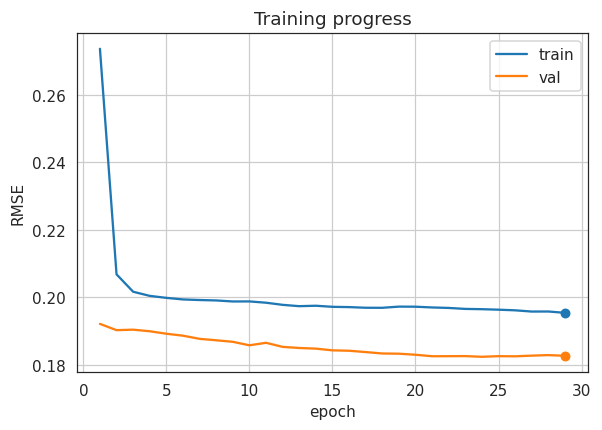

In [10]:
# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
